In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np

# sklearn
from imblearn.over_sampling import SMOTE
# modeli
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# ostalo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, normalize
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Sklearn Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# scipy
import scipy
from scipy import ndimage #za gaussijanski filter
from scipy.signal import savgol_filter
from scipy.stats import zscore
from scipy.fft import rfft, rfftfreq

#crtanje
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()
sns.set(style="white")

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class FastFourierTransform(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        transformed = np.abs(rfft(X, axis=1))
        return transformed
    
class SavGolTransform(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        transformed = savgol_filter(X,101,2,deriv=0)
        transformed = np.array(X) - transformed
        return transformed

class NormalizeTransform(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        transformed = normalize(X)
        return transformed
    
class MovingAverage(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        transformed = []
        X = np.array(X)
        for i in range(len(X)):
            	transformed.append(self.moving_average(X[i],200))
        return np.array(transformed)
    def moving_average(self, x, w):
        return np.convolve(x, np.ones(w)/w, 'valid')
    
class GaussianFilter(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        transformed = ndimage.filters.gaussian_filter(X, sigma=10)
        return np.array(X)-transformed

In [3]:
# Učitaj nanovo podatke bez ikakvih transformacija
def reset_data(df_train, df_test):
    train = df_train.copy()
    test = df_test.copy()
    
    #pretvori LABEL u tvrdnje istinitosti 0 i 1
    train["LABEL"] = train["LABEL"].apply(lambda x: 0 if x==1 else 1)
    test["LABEL"] = test["LABEL"].apply(lambda x: 0 if x==1 else 1)
    
    #razdvoji feature i labele
    X_train = train.drop(["LABEL"], axis = 1)
    y_train = train["LABEL"].ravel()
    X_test = test.drop(["LABEL"], axis = 1)
    y_test = test["LABEL"].ravel()
    
    #makni retke koji sadrže outliere u train data
    zscores = zscore(X_train)
    abszscores = np.abs(zscores)
    filtered_indices = (abszscores<3).all(axis=1)
    X_train = X_train[filtered_indices]
    y_train = y_train[filtered_indices]
    
    #ispuni outliere retka sa srednjom vrijednosti retka
#     data_std = X_train.std(axis=1)
#     data_mean = X_train.mean(axis=1)
#     cut = data_std*3

#     outliers = []
#     for i in range(len(X_train)):
#         outliers.append(X_train.iloc[i]>cut[i])
    
#     X_train[np.array(outliers)] = np.nan
    
#     for i in range(len(X_train)):
#         X_train.iloc[i].fillna(data_mean[i], inplace=True)
    
    return X_train, X_test, y_train, y_test

In [4]:
def draw_exo(data, n):
    if isinstance(data,np.ndarray):        
        fig = plt.figure(figsize=(24,40))
        for i in range(n):
            ax = fig.add_subplot(14,4,i+1)
            #ax.scatter(np.arange(len(data[0])),data[i][:],s=0.5)
            ax.plot(np.arange(len(data[0])),data[i][:], lw=0.5)
    else:
        fig = plt.figure(figsize=(24,40))
        for i in range(n):
            ax = fig.add_subplot(14,4,i+1)
            ax.plot(np.arange(len(X_train.iloc[0])),data.iloc[i,:],lw=0.5)
            #ax.plot(np.arange(len(data[0])),data[i][:], lw=0.5)

def draw_noexo(data, n):
    if isinstance(data,np.ndarray):
        fig = plt.figure(figsize=(24,40))
        for i in range(n):
            ax = fig.add_subplot(14,4,i+1)
            #ax.scatter(np.arange(len(data[0])),data[i+37][:],s=0.5)
            ax.plot(np.arange(len(data[0])),data[i+37][:], lw=0.5)
    else:
        fig = plt.figure(figsize=(24,40))
        for i in range(n):
            ax = fig.add_subplot(14,4,i+1)
            ax.plot(np.arange(len(X_train.iloc[0])),data.iloc[i+37,:],lw=0.5)
            #ax.plot(np.arange(len(data[0])),data[i+37][:], lw=0.5)

In [5]:
data_prep_1 = Pipeline([("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform()),
                      ("robust_scaler", RobustScaler()),
                      ("fft", FastFourierTransform())])

data_prep_2 = Pipeline([("fft", FastFourierTransform()),
                      ("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform()),
                      ("robust_scaler", RobustScaler()),])

data_prep_3 = Pipeline([("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform()),
                      ("robust_scaler", RobustScaler()),])

data_prep_4 = Pipeline([("fft", FastFourierTransform()),
                      ("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform()),
                      ("std_scaler", StandardScaler()),])

data_prep_5 = Pipeline([("savgol", SavGolTransform()),
                        ("normalizer", NormalizeTransform()),
                        ("fft", FastFourierTransform()),
                        #("savgol", SavGolTransform()),
                        #("normalizer", NormalizeTransform()),
                        ("std_scaler", StandardScaler()),
                        #("savgol", SavGolTransform())
                        ])

data_prep_6 = Pipeline([("std_scaler", StandardScaler()),
                        ("moving_average", MovingAverage()),
                        ("fft", FastFourierTransform()),
                        ("savgol", SavGolTransform()),
                        
                        
                        
                      #("savgol", SavGolTransform()),
                      ])

In [6]:
#funkcija za testiranje modela
def test_model(estimator, X_train_, X_test_, y_train_, y_test_):
    estimator.fit(X_train_, y_train_)
    prediction=estimator.predict(X_test_)
    print()
    print(type(estimator).__name__)
    print()
    #ispis svih vrijednosti
    print(classification_report(y_test,prediction))
    #crtanje
    fig = plt.figure(figsize=(22,7), num=type(estimator).__name__)
    ax = fig.add_subplot(1,3,1)
    sns.heatmap(confusion_matrix(y_test_,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    ax = fig.add_subplot(1,3,2)
    metrics.plot_roc_curve(estimator, X_test_, y_test_, ax=ax)
    plt.plot([0, 1], [0, 1], 'k--')
    ax = fig.add_subplot(1,3,3)
    metrics.plot_precision_recall_curve(estimator, X_test_, y_test_, ax=ax)
    f1=metrics.f1_score(y_test_, prediction)
    print("F1:", f1)

In [7]:
print("Loading data...")
train_data = pd.read_csv("exoTrain.csv")#.fillna(0)
test_data = pd.read_csv("exoTest.csv")#.fillna(0)
print("Data loaded.")

Loading data...
Data loaded.


In [42]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)

In [45]:
X_train.shape
#X_test.shape

(5010, 3197)

In [8]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_5.fit_transform(X_train)
X_test = data_prep_5.fit_transform(X_test)

# sm = SMOTE(random_state=42, n_jobs=-1)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

Wall time: 3.52 s


In [58]:
np.logspace(-5,4,10)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04])

In [9]:
parameters = {
    "max_iter": [2000],
    "C": np.logspace(-5,4,10)#np.linspace(1e-1,1,11) #list(range(0,21))#C,#np.arange(0,1.1,0.1),
    #"class_weight": [None, "Balanced"],
    #"solver": ["lbfgs"],
    #"fit_intercept": [True, False],
    #"penalty": ["l2"]
}
 #   "random_state": [42],
# logreg = LogisticRegression(max_iter=500, n_jobs=-1, random_state=42, verbose=1, class_weight="balanced")

logreg = LogisticRegression()

grid = GridSearchCV(logreg, parameters, cv=5, verbose=3, n_jobs=-1, return_train_score=True, scoring = ["recall","precision","f1"], refit="recall")

In [10]:
grid.fit(X_train, y_train)
grid.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.9s finished


LogisticRegression(C=10000.0, max_iter=2000)

In [61]:
grid.score(X_test,y_test)
grid.best_estimator_.score(X_test, y_test)
y_pred = grid.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[564,   1],
       [  2,   3]], dtype=int64)

# [562,   3]
# [  0,   5]

# [563,   2]
# [  1,   4]

In [11]:
import joblib
#joblib.dump(grid, "logreg-962021-4.pkl")
#loaded_grid = joblib.load("logreg-17520211552.pkl") #logreg-17520211552.pkl

In [72]:
# y_pred = loaded_grid.best_estimator_.predict(X_test)
# confusion_matrix(y_test, y_pred)

array([[557,   8],
       [  1,   4]], dtype=int64)

In [63]:
grid.best_estimator_

LogisticRegression(C=10000.0, max_iter=2000)

In [12]:
results = pd.DataFrame(grid.cv_results_)
#results[["param_C", "param_class_weight", "rank_test_precision"]]
#results.columns

Text(0.5, 1.0, '')

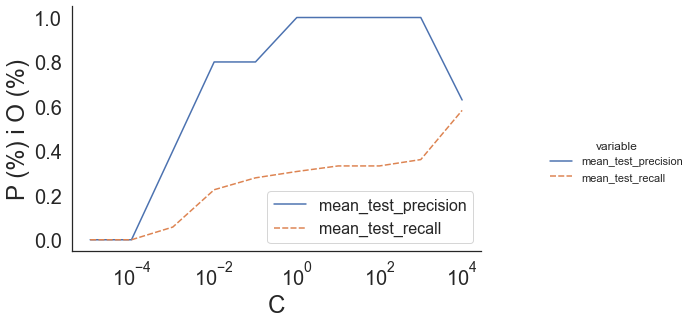

In [18]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 


results = pd.DataFrame(grid.cv_results_)
removed = list(results.columns)
removed.remove("mean_test_precision")
removed.remove("mean_test_recall")
res = results.melt(id_vars=removed, value_vars=["mean_test_precision", "mean_test_recall"])

p1 = sns.relplot(
    data=res, kind="line",
    x="param_C", y="value", hue="variable", style="variable"#, col="param_class_weight",# col="param_criterion", #col="param_criterion",
    #facet_kws=dict(sharey=True),
)
p1.fig.set_size_inches(10,4)
p1.set(xscale="log")
#p1.set(xticks=np.linspace(1e-5,1e-4,4).round(5))
#p1.set(xlim=(-0.0001,0.001))

#p1.set(ylabel="%", xlabel="C")
plt.xlabel("C", fontsize=24)
plt.ylabel("P (%) i O (%)", fontsize=24)
plt.legend(fontsize=16, loc="lower right")
plt.title(label="")

Text(28.723478472222226, 0.5, '%')

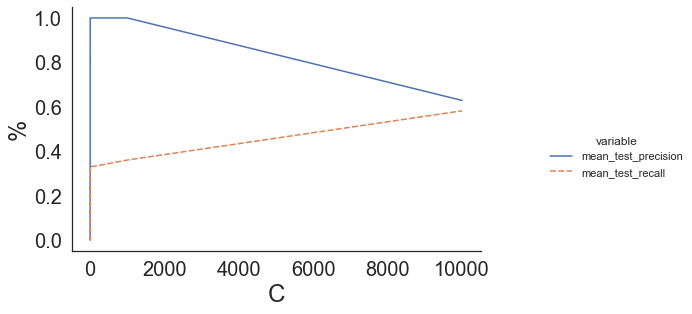

In [73]:
results = pd.DataFrame(grid.cv_results_)
removed = list(results.columns)
removed.remove("mean_test_precision")
removed.remove("mean_test_recall")
res = results.melt(id_vars=removed, value_vars=["mean_test_precision", "mean_test_recall"])

p1 = sns.relplot(
    data=res, kind="line",
    x="param_C", y="value", hue="variable", style="variable"#, col="param_class_weight",# col="param_criterion", #col="param_criterion",
    #facet_kws=dict(sharey=True),
)
p1.fig.set_size_inches(10,4)
#p1.set(xscale="log")
#p1.set(xticks=np.linspace(1e-5,1e-4,4).round(5))
#p1.set(xlim=(-0.0001,0.001))

#p1.set(ylabel="%", xlabel="C")
plt.xlabel("C", fontsize=24)
plt.ylabel("%", fontsize=24)

In [161]:
np.linspace(1e-5,1e-4,10)

array([1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05,
       9.e-05, 1.e-04])

Text(0.5, 1.0, '')

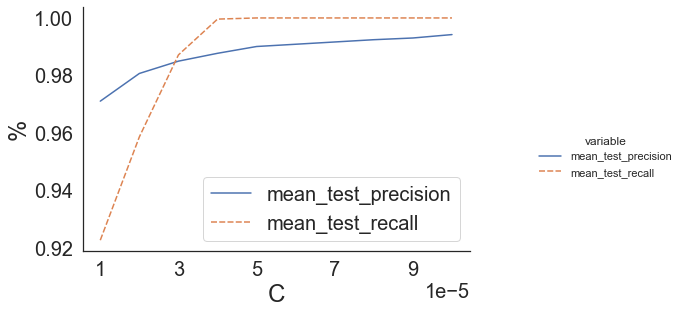

In [97]:
import joblib
#logreg-240520211332.pkl
#results = joblib.load("logreg-240520211332.pkl")
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

results = joblib.load("logreg-962021-4.pkl")
#logreg 2 i 4 su dobitnici

results = pd.DataFrame(results.cv_results_)

removed = list(results.columns)
removed.remove("mean_test_precision")
removed.remove("mean_test_recall")
res = results.melt(id_vars=removed, value_vars=["mean_test_precision", "mean_test_recall"])

p1 = sns.relplot(
    data=res, kind="line",
    x="param_C", y="value", hue="variable", style="variable", #col="param_class_weight", #col="param_criterion",
    #facet_kws=dict(sharey=True),
)
p1.fig.set_size_inches(10,4)
#p1.set(xscale="log")
p1.set(xticks=[1e-5, 3e-5, 5e-5, 7e-5, 9e-5,])
#p1.set(xticks=[10e-6, 10e-4, 10e-2, 10e0, 10e2])
#p1.set(ylabel="%", xlabel="C")
plt.xlabel("C", fontsize=24)
plt.ylabel("%", fontsize=24)
plt.legend(fontsize=20)
plt.title(label="")

In [27]:
# from sklearn.ensemble import VotingClassifier
# logreg = LogisticRegression(C=10.0, max_iter=1000, n_jobs=-1)
# tree = DecisionTreeClassifier(criterion='entropy', max_depth=6)
# forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
# voting = VotingClassifier(estimators=[("lr", logreg), ("tree", tree)], voting="soft", n_jobs=-1)

In [34]:
# %%time
# voting.fit(X_train,y_train)
# y_pred = voting.predict(X_test)
# confusion_matrix(y_test, y_pred)

In [35]:
# %%time
# for clf in (logreg,tree,forest,voting):
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

In [123]:
#funkcija za testiranje modela
def test_model(estimator, X_train_, X_test_, y_train_, y_test_):
    estimator.fit(X_train_, y_train_)
    prediction=estimator.predict(X_test_)
    print()
    print(type(estimator).__name__)
    print()
    #ispis svih vrijednosti
    print(classification_report(y_test,prediction))
    #crtanje
    fig = plt.figure(figsize=(16,4), num=type(estimator).__name__)
    ax = fig.add_subplot(1,3,1)
    sns.heatmap(confusion_matrix(y_test_,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    ax = fig.add_subplot(1,3,2)
    metrics.plot_roc_curve(estimator, X_test_, y_test_, ax=ax)
    plt.plot([0, 1], [0, 1], 'k--')
    ax = fig.add_subplot(1,3,3)
    metrics.plot_precision_recall_curve(estimator, X_test_, y_test_, ax=ax)
    f1=metrics.f1_score(y_test_, prediction)
    print("F1:", f1)

In [131]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_5.fit_transform(X_train)
X_test = data_prep_5.fit_transform(X_test)

sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, counts of label '1': 4974
After OverSampling, counts of label '0': 4974
Wall time: 3.81 s


In [134]:
%%time
logreg = LogisticRegression(C=4*1e-5,max_iter=1000, n_jobs=-1)
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)
# confusion_matrix(y_test,y_pred)
tree = DecisionTreeClassifier(criterion="entropy", max_depth=8, max_leaf_nodes=22, random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
confusion_matrix(y_test,y_pred)
#test_model(logreg, X_train, X_test, y_train, y_test)

Wall time: 16.5 s


array([[557,   8],
       [  2,   3]], dtype=int64)

In [168]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_5.fit_transform(X_train)
X_test = data_prep_5.fit_transform(X_test)

sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, counts of label '1': 4974
After OverSampling, counts of label '0': 4974
Wall time: 3.83 s


In [154]:
%%time
from sklearn.ensemble import VotingClassifier
logreg = LogisticRegression(C=4*1e-5,max_iter=1000, n_jobs=-1)
tree = DecisionTreeClassifier(criterion="entropy", max_depth=8, max_leaf_nodes=22, random_state=71)
voter = VotingClassifier(estimators=[("lr", logreg), ("tree", tree)], voting="soft")

Wall time: 0 ns



VotingClassifier

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       565
           1       0.36      0.80      0.50         5

    accuracy                           0.99       570
   macro avg       0.68      0.89      0.75       570
weighted avg       0.99      0.99      0.99       570

F1: 0.5000000000000001
Wall time: 19.5 s


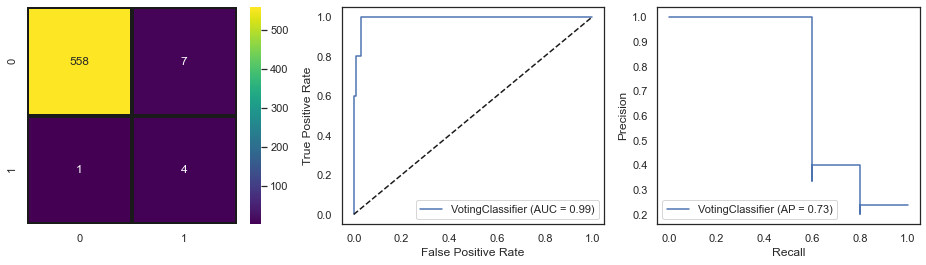

In [130]:
%%time
test_model(voter, X_train, X_test, y_train, y_test)

In [155]:
%%time
voter.fit(X_train, y_train)
y_pred = voter.predict(X_test)
confusion_matrix(y_test,y_pred)

Wall time: 17.8 s


array([[557,   8],
       [  1,   4]], dtype=int64)

In [133]:
#logreg
np.argwhere(y_pred).flatten()

array([  0,   1,   2,   4, 124, 136, 137, 368, 372, 506], dtype=int64)

In [135]:
#tree
np.argwhere(y_pred).flatten()

array([  0,   2,   4,  29,  67, 141, 287, 342, 372, 448, 506], dtype=int64)

In [156]:
#voter
np.argwhere(y_pred).flatten()

array([  0,   1,   2,   4,  29,  67, 141, 159, 287, 342, 372, 394],
      dtype=int64)

In [164]:
a = np.array([  0,   1,   2,   4, 124, 136, 137, 368, 372, 506]) #logreg
b = np.array([  0,   2,   4,  29,  67, 141, 287, 342, 372, 448, 506]) #tree
c = np.array([  0,   1,   4,  29,  67, 141, 287, 342, 372, 394]) #ansambl
c = np.array([  0,   1,   2,   4,  29,  67, 141, 159, 287, 342, 372, 394])
np.intersect1d(a,b)
np.intersect1d(b,c)
np.unique(np.concatenate((a,b,c)))

array([  0,   1,   2,   4,  29,  67, 124, 136, 137, 141, 159, 287, 342,
       368, 372, 394, 448, 506])

In [62]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
confusion_matrix(y_test,y_pred)
np.argwhere(y_pred).flatten()

array([  0,   1,   2,   3,   4, 104, 109, 124, 136, 137, 185, 258, 264,
       279, 285, 487, 506, 513, 537], dtype=int64)

# 159 i 372 mogući kandidati

In [30]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_5.fit_transform(X_train)
X_test = data_prep_5.fit_transform(X_test)

Text(0.07, 0.5, 'Normalizirana amplituda intenziteta svjetlosti [$e^{-}s^{-1}$]')

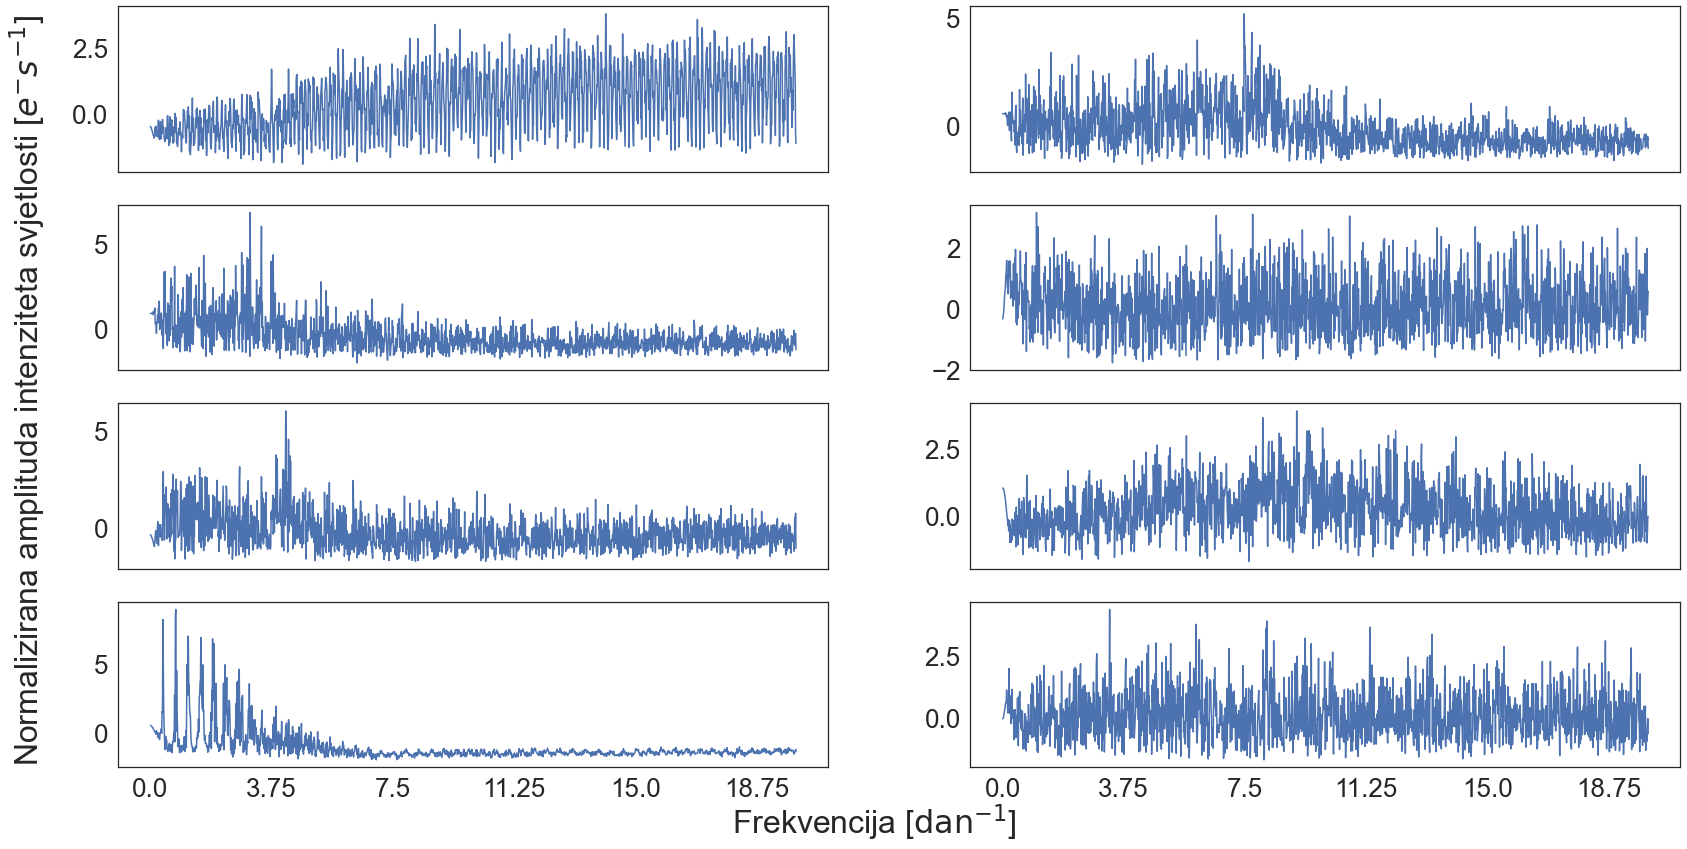

In [31]:
import scipy
# scale = scipy.fft.rfftfreq(3197, d=0.025)
# scale_labels = scale[::300].round()
# scale_ticks = list(range(1599))[::300]
scale = scipy.fft.rfftfreq(3197, d=80/3197)
scale_labels = scale[::300].round(3)
scale_ticks = list(range(1599))[::300]

plt.rc('xtick', labelsize=26) 
plt.rc('ytick', labelsize=26) 
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(28,14), sharex="all")

plt.setp(ax, xticks=scale_ticks, xticklabels=scale_labels)
x = X_test[[29,  67, 141, 159, 287, 342, 372, 394]]
k = 0
for i in range(4):
    for j in range(2):
        ax[i,j].plot(np.arange(len(x[0])),x[k,:], )#s=0.2)
        #ax[i,j].set_xticks(list(range(0,3197,40)),list(range(1,81)))
        k+=1

fig.text(0.5, 0.06, r"Frekvencija [$\mathrm{dan}^{-1}$]", ha='center', fontsize=32)
fig.text(0.07, 0.5, "Normalizirana amplituda intenziteta svjetlosti [$e^{-}s^{-1}$]", va='center', rotation='vertical', fontsize=32)

#fig.savefig("Slike/ansambl_false_positives.png")

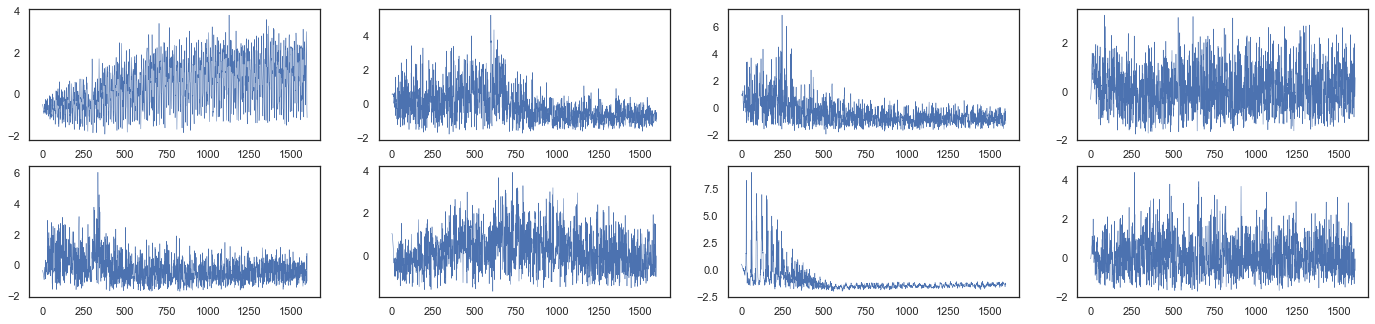

In [170]:
X_test = np.array(X_test)
x = X_test[[  0,   1,   2, 3, 4, 487, 124, 506]]
x = X_test[[ 21,  39, 124, 258, 470, 513, 514, 545]]
x = X_test[[ 104, 109, 124, 136, 137, 185, 258, 264,
       279, 285, 487, 506, 513, 537]]
x = X_test[[ 29,  67, 141, 159, 287, 342, 372]]
x = X_test[[29,  67, 141, 159, 287, 342, 372, 394]]
#x = X_test[[29,  67, 124, 136, 137, 141, 159, 287, 342,368, 372, 394, 448, 506]]
#159 i 372

draw_exo(x,len(x))

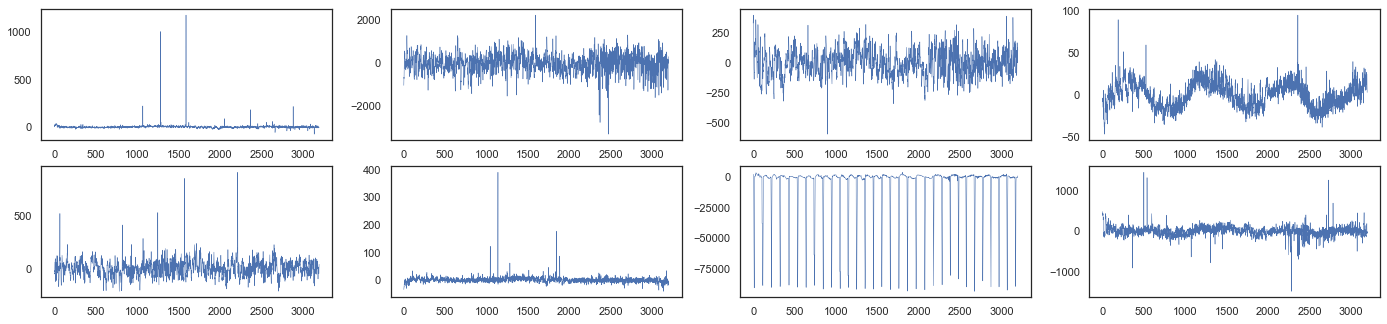

In [171]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_test = np.array(X_test)
# x = X_test[[  0,   1,   2, 3, 4, 124, 487, 506]]
# x = X_test[[ 21,  39, 124, 258, 470, 513, 514, 545]]
# x = X_test[[ 104, 109, 124, 136, 137, 185, 258, 264,
#        279, 285, 487, 506, 513, 537]]
x = X_test[[ 29,  67, 141, 159, 287, 342, 372]]
x = X_test[[29,  67, 141, 159, 287, 342, 372, 394]]
#x = X_test[[29,  67, 124, 136, 137, 141, 159, 287, 342,368, 372, 394, 448, 506]]

#x = X_test[[ 29,  67, 141, 287, 342, 372, 448, 506]]
draw_exo(x,len(x))

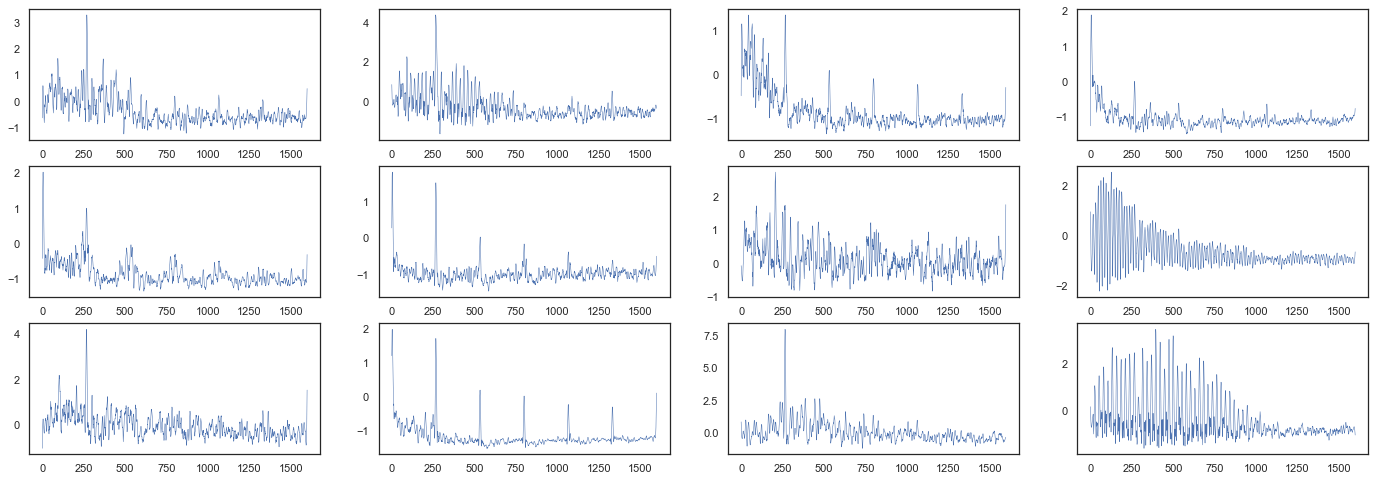

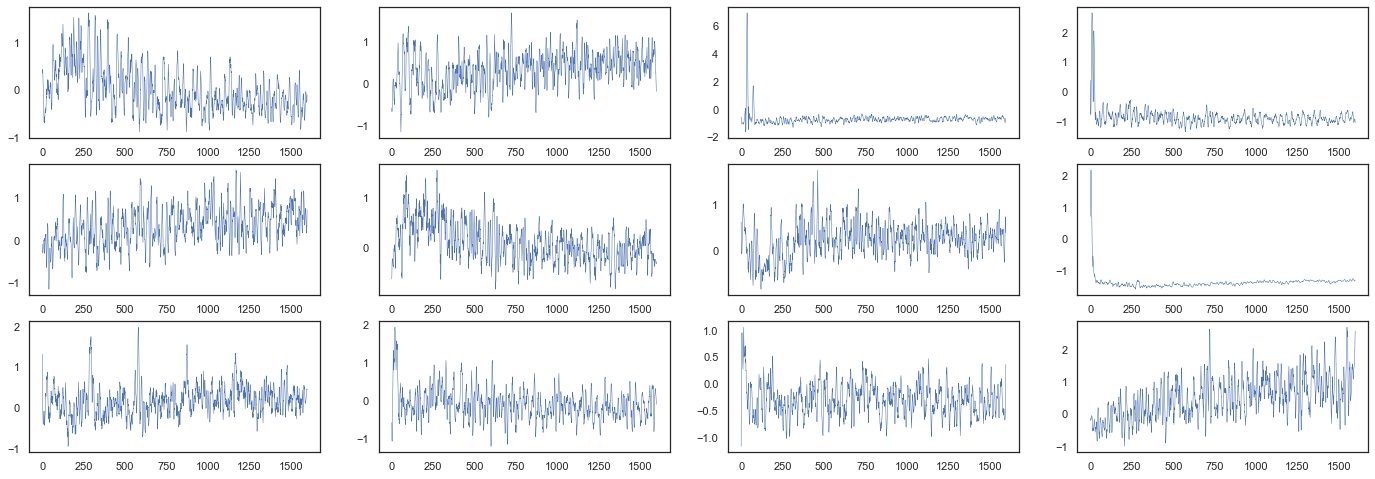

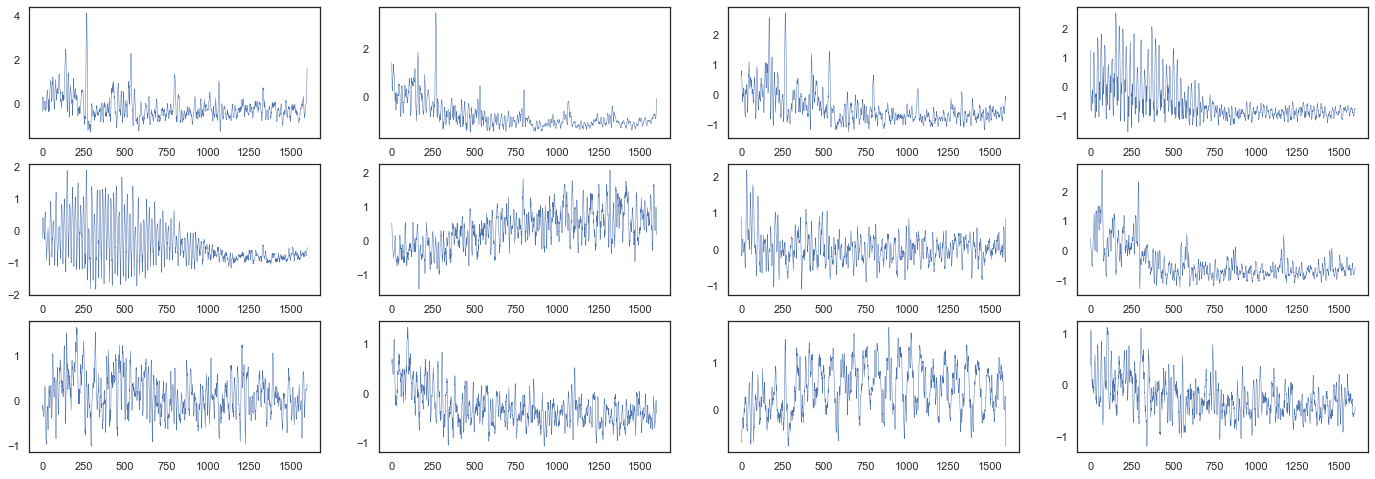

In [13]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_5.fit_transform(X_train)
X_test = data_prep_5.fit_transform(X_test)
draw_exo(X_train,12)
draw_noexo(X_train,12)
draw_exo(X_test,12)

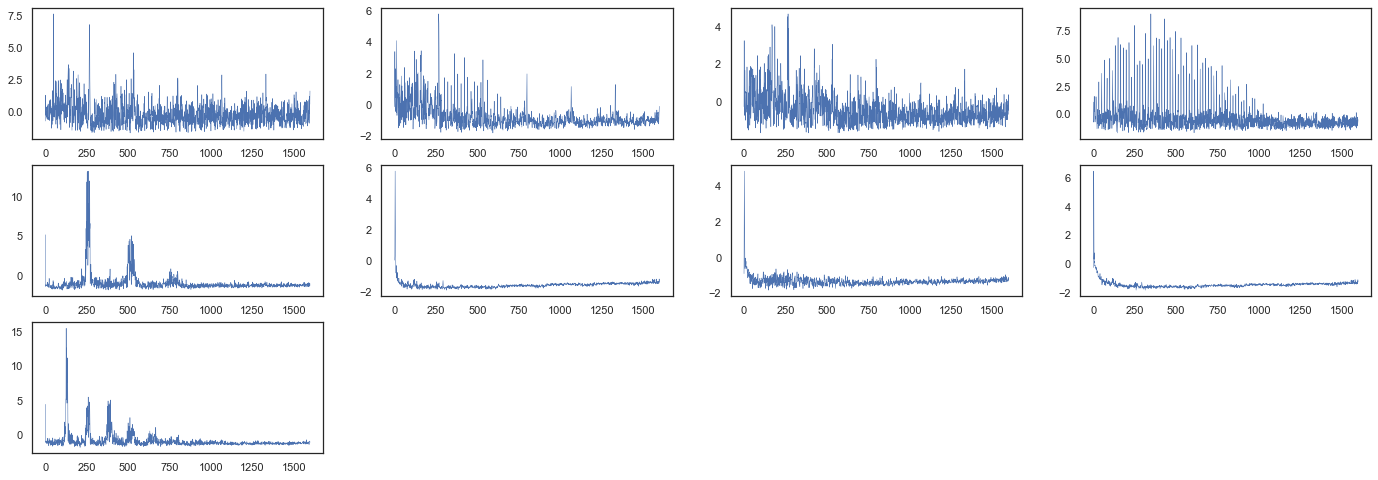

In [55]:
draw_exo(X_test[y_pred==1],len(X_test[y_pred==1]))

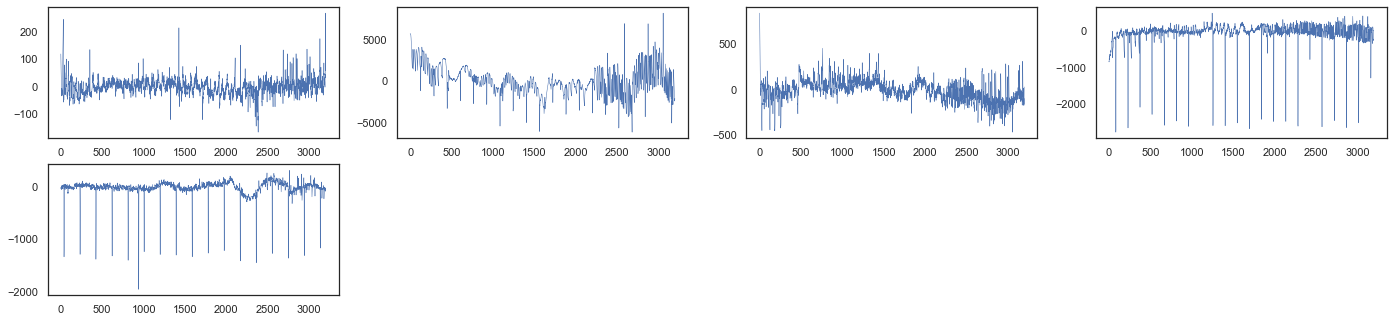

In [200]:
draw_exo(X_test[y_test==1],5)

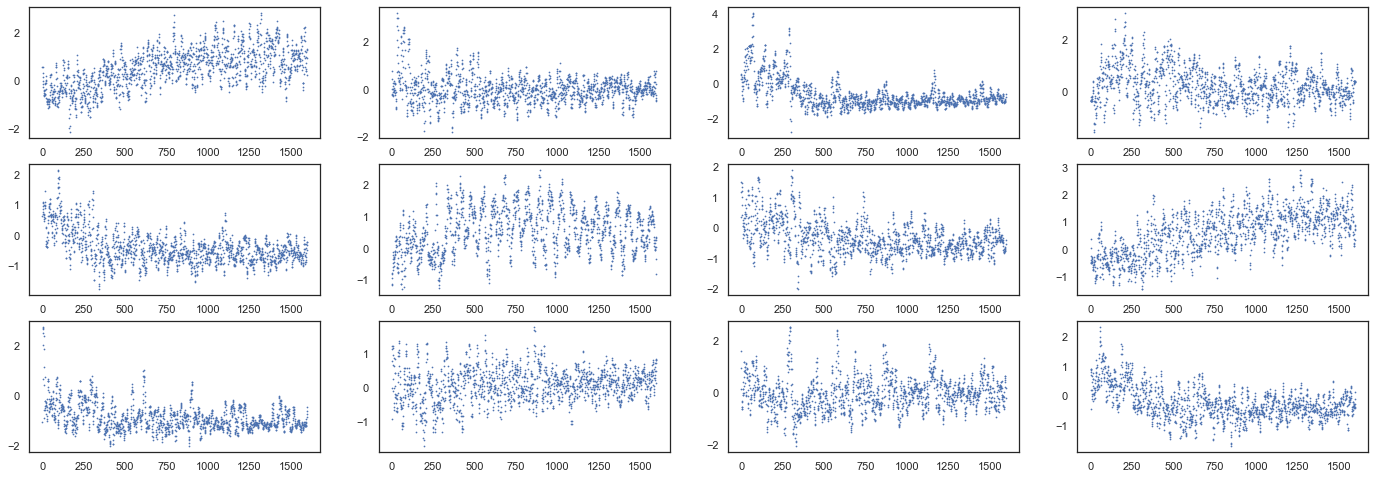

In [159]:
draw_exo(X_test[y_test==0],12)

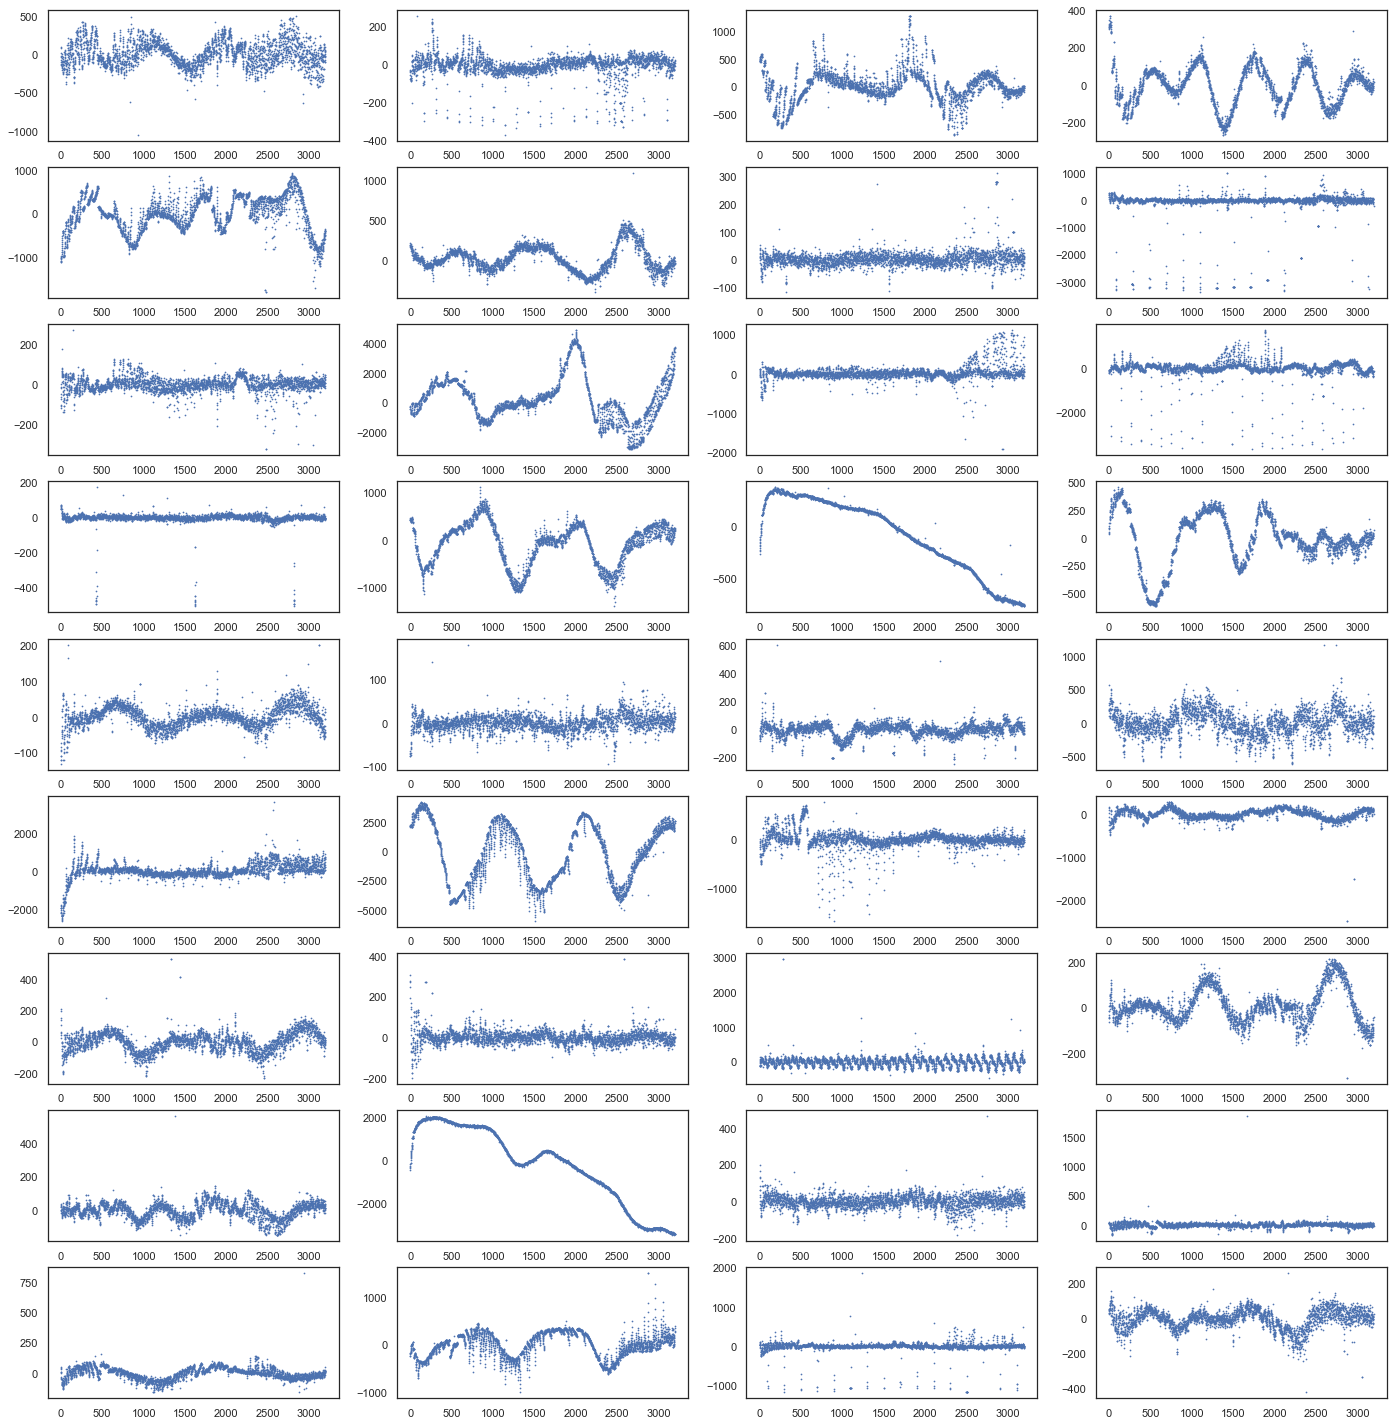

In [201]:
draw_exo(X_train[y_train==1],36)

In [ ]:
0,2,4,364,

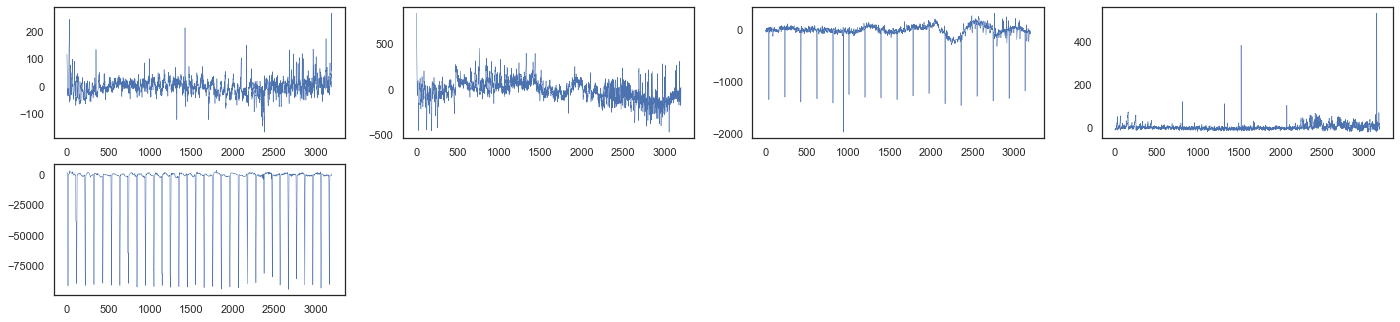

In [198]:
x = X_test[[0,2,4,356,372]]
draw_exo(x,len(x))

In [188]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)

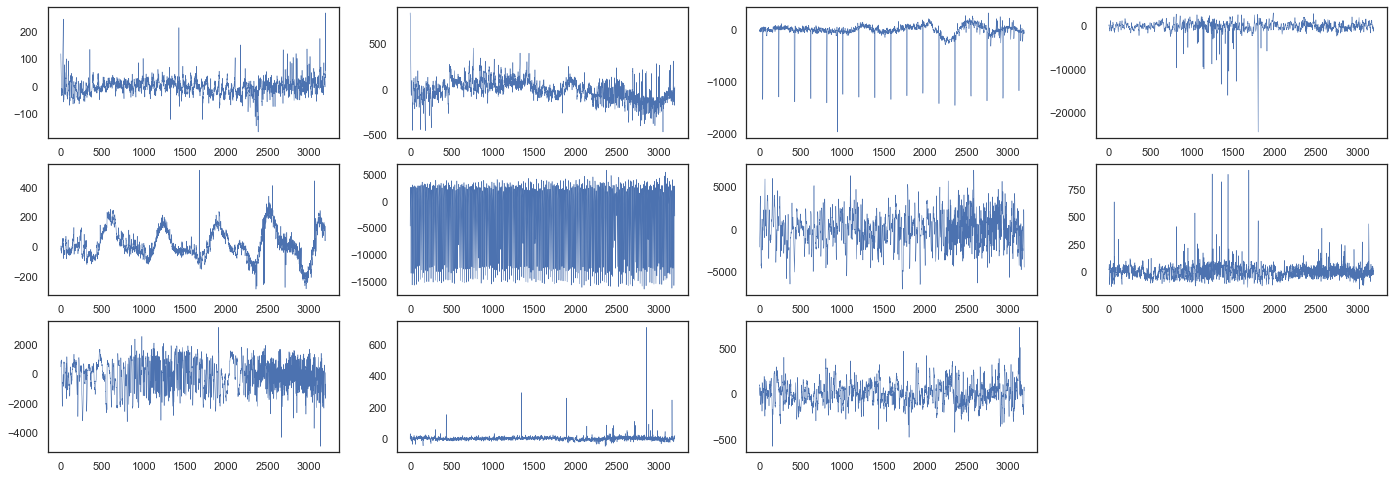

In [189]:
X_test = np.array(X_test)
x = X_test[[0,1,2,4,356,372, 124, 230, 460, 485, 506]]
x = X_test[[0,   1,   2,   3,   4,  21, 109, 124, 137, 264, 279, 487, 506,
       513, 537, 563]]
x = X_test[[  0,   2,   4,  21,  39, 124, 258, 470, 513, 514, 545]]

draw_exo(x,len(x))

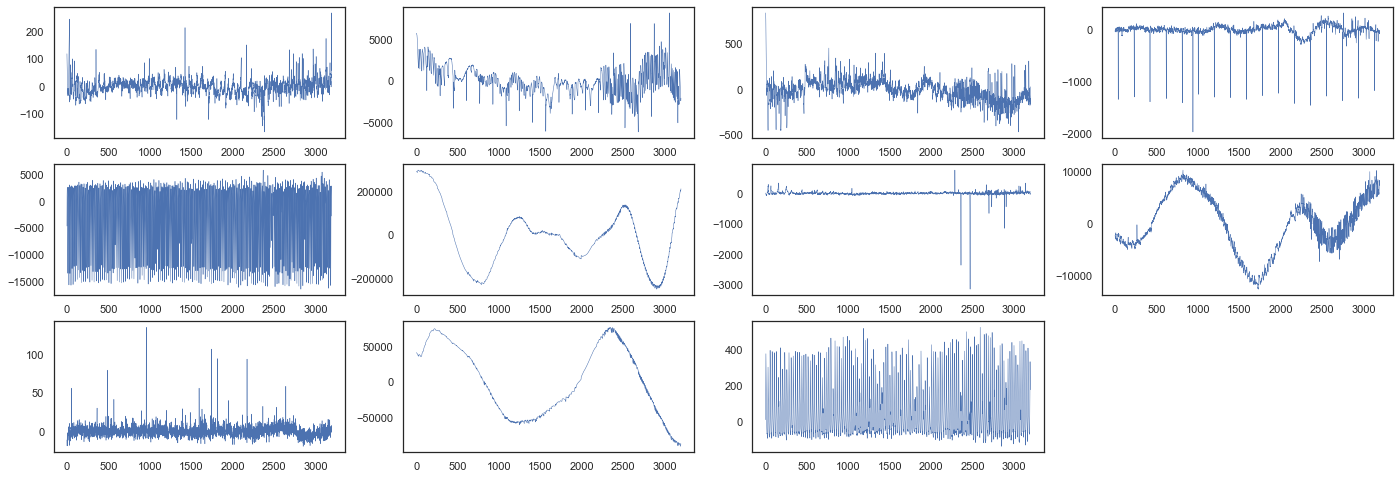

In [202]:
draw_exo(X_test[y_pred==1],11)

In [221]:
a = np.argwhere(y_pred)

In [222]:
b = np.array([[  0],
       [  2],
       [  4],
       [207],
       [304],
       [306],
       [364],
       [395],
       [506],
       [525]], dtype="int64")

In [223]:
np.intersect1d(a,b)

array([  0,   2,   4, 364, 506], dtype=int64)

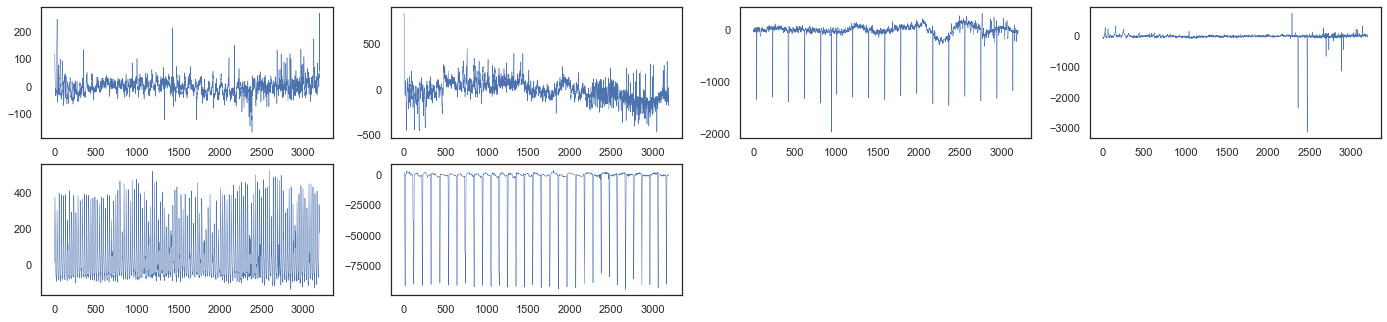

In [224]:
X_test = np.array(X_test)
x = X_test[[  0,   2,   4, 364, 506, 372]]
draw_exo(x,len(x))

In [268]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_5.fit_transform(X_train)

In [459]:
# plt.figure(figsize=(22,8))
# plt.scatter(list(range(1599)),X_train[4])

In [371]:
def detrender_normalizer(X):
    flux1 = X
    flux2 = ndimage.filters.gaussian_filter(flux1, sigma=10)
    flux3 = flux1 - flux2
    flux3normalized = (flux3-np.mean(flux3)) / (np.max(flux3)-np.min(flux3))
    return flux3normalized

In [449]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
std_scaler = StandardScaler()


# std_scaler.fit(X_train)
# X_train = std_scaler.transform(X_train)
#X_train = pd.DataFrame(SavGolTransform().transform(X_train))
X_train = X_train.apply(detrender_normalizer,axis=1)
#X_train = NormalizeTransform().transform(X_train)
# X = SavGolTransform().transform(X_train)
# X_train = np.array(X_train)-X
# X_train = NormalizeTransform().transform(X_train)
X_train = pd.DataFrame(FastFourierTransform().transform(X_train))



# std_scaler.fit(X_train)
# X_train = std_scaler.transform(X_train)
#X_test = pd.DataFrame(SavGolTransform().transform(X_test))
X_test = X_test.apply(detrender_normalizer,axis=1)
#X_test = NormalizeTransform().transform(X_test)
# X = SavGolTransform().transform(X_test)
# X_test = np.array(X_test)-X
# X_test = NormalizeTransform().transform(X_test)
X_test = pd.DataFrame(FastFourierTransform().transform(X_test))


sm = SMOTE(random_state=42, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, counts of label '1': 4974
After OverSampling, counts of label '0': 4974


In [450]:
logreg = LogisticRegression(C=8,max_iter=1000, n_jobs=-1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[563,   2],
       [  2,   3]], dtype=int64)

In [451]:
np.argwhere(y_pred)

array([[  0],
       [  1],
       [  2],
       [124],
       [506]], dtype=int64)

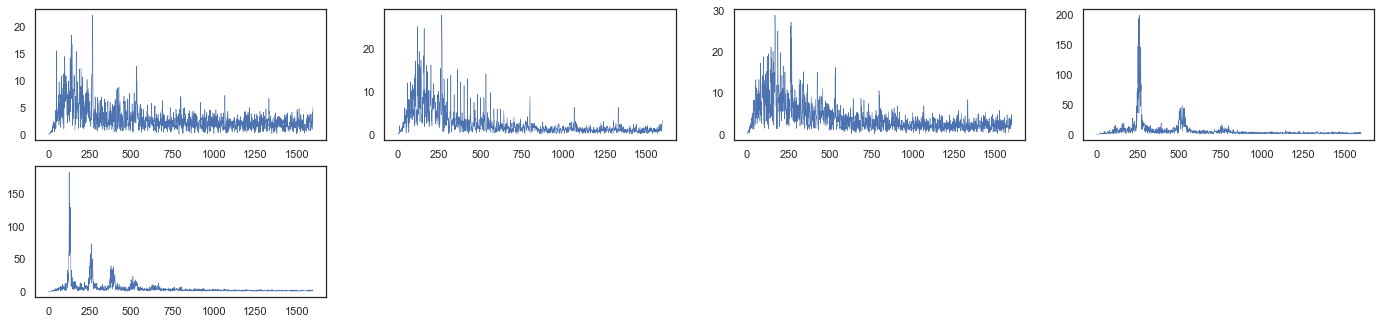

In [452]:
x = X_test[y_pred==1]
draw_exo(x,len(x))
#plt.plot(X_test)

In [456]:
#draw_exo(X_train,12)

In [457]:
#draw_noexo(X_train,12)